# Feature Engineering

The main objectives for this notebook are:
* Develop a set of features that have a potential to improve our model's performance
* Investiage the relationships between our new features and your target


## important steps 
1. Engineer a well argued feature (if with sources that's bonus point x2) 
2. Validate features after engineering
3. Don't use blind (auto) feature engineering - waste of time
    - Irrelevant Features Can Reduce Model Performance
    - Difficulty in Model Interpretability and Explainability
    - Lack of Alignment with Business Goals
4. Design a feature engineering pipeline at the end of the notebook

# Imports

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import seaborn as sns
from feature_engine.selection import SmartCorrelatedSelection

import polars as pl

# Path needs to be added manually to read from another folder
path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "utils"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

from feature_engineering import (
    aggregate_node_features
    # feature_predictive_power,
    # get_graph_features,
)

pio.renderers.default = "notebook"

In [3]:
data = pl.read_parquet('../data/supervised_clean_data.parquet')
calls = pl.read_json('../data/supervised_call_graphs.json')

In [4]:
data.head(1)

,_id,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification,is_anomaly
i64,str,f64,f64,f64,i64,str,f64,f64,f64,str,str,bool
0,"""1f2c32d8-2d6e-3b68-bc46-789469…",0.000812,0.004066,85.643243,5405,"""default""",1460.0,1295.0,451.0,"""E""","""normal""",false


In [5]:
calls.head(1)

_id,call_graph
str,list[struct[2]]
"""1f2c32d8-2d6e-3b68-bc46-789469…","[{""1f873432-6944-3df9-8300-8a3cf9f95b35"",""5862055b-35a6-316a-8e20-3ae20c1763c2""}, {""8955faa9-0e33-37ad-a1dc-f0e640a114c2"",""a4fd6415-1fd4-303e-aa33-bb1830b5d9d4""}, … {""016099ea-6f20-3fec-94cf-f7afa239f398"",""6fa8ad53-2f0d-3f44-8863-139092bfeda9""}]"


Since the main dataset already contains engineered features, there's not much opportunity to do feature engineering there. So, additional features will be created using the graph data that comes from `supervised_call_graphs.json`

## Process Graph Data

In [6]:
calls_processed = (
    calls.with_columns(
        pl.col("call_graph").list.eval(
            pl.element().struct.rename_fields(["from", "to"])
        )
    )
    .explode("call_graph")
    .unnest("call_graph")
)

calls_processed.head()

_id,from,to
str,str,str
"""1f2c32d8-2d6e-3b68-bc46-789469…","""1f873432-6944-3df9-8300-8a3cf9…","""5862055b-35a6-316a-8e20-3ae20c…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""8955faa9-0e33-37ad-a1dc-f0e640…","""a4fd6415-1fd4-303e-aa33-bb1830…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""85754db8-6a55-30b7-8558-dec75f…","""85754db8-6a55-30b7-8558-dec75f…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""9f08fee1-953c-3801-b254-c0256f…","""876b4958-7df1-3b2b-9def-1a22f1…"
"""1f2c32d8-2d6e-3b68-bc46-789469…","""857c4b20-3057-30e0-9ca3-d6f5c3…","""857c4b20-3057-30e0-9ca3-d6f5c3…"


## Feature Engineering

We can see that each graph has a separate `_id` that can be later used to join to the main dataset. A graph consistst out of `source` and `destination` nodes which refer to the available API calls.

### Basic Graph Level Features

The most basic graph-level that we can engineer are:
* Number of edges (connections)
* Number of nodes (APIs)

These features can be useful since most behaviours are going to have a "normal" range of APIs that they contact. If this number is too large or too small, this might be an indication of anomalous activity.

In [7]:
graph_features = calls_processed.group_by('_id').agg(
    pl.len().alias('n_connections'),
    pl.col('from'),
    pl.col('to')
).with_columns(
    pl.concat_list('from', 'to').list.unique().list.len().alias('n_unique_nodes')
).select([
    '_id',
    'n_connections',
    'n_unique_nodes'
])

graph_features.sample(3)

_id,n_connections,n_unique_nodes
str,u32,u32
"""765d954e-cfec-3fd3-b3f6-b8c4d3…",135,33
"""5654cc55-2810-3103-8401-22678d…",1,1
"""2bde266b-276e-3aac-9606-9a4ce1…",11,6


### Node Level Features

Since graphs consist out of nodes, we can engineer a set of features around specific nodes (APIs). We can calculate:

* Node degrees -  the number of edges that come from/into a node. Very highly connected nodes can look anomalous.
* Node centrality - there are various centrality measures (e.g. Page Rank) but they all try to estimate how important to the whole graph is a specific node. This feature could be useful because a behaviour pattern that doesn't touch any of the "central" APIs would look anomalous


These features can be broken down into:
* **global** features - measure node attributes across all the graphs
* **local**  features - measure node attributes across a specific graph


In [8]:
calls_processed = calls_processed.with_columns(
    global_source_degrees = pl.len().over(pl.col('from')),
    global_dest_degrees = pl.len().over(pl.col('to')),
    local_source_degrees = pl.len().over(pl.col('from'), pl.col('_id')),
    local_dest_degrees = pl.len().over(pl.col('to'), pl.col('_id'))
)

calls_processed.sample(3)

_id,from,to,global_source_degrees,global_dest_degrees,local_source_degrees,local_dest_degrees
str,str,str,u32,u32,u32,u32
"""1a70af14-26eb-35dd-a3a2-113a92…","""699caece-830f-3194-ae24-7b4563…","""aadf8ca9-ffda-30f0-bacf-2203e8…",695,20489,5,12
"""b00a8232-9d49-342d-8f19-980b36…","""7e28996d-92dc-3592-8704-e3ce25…","""97288012-ad48-302a-8180-dff7e9…",413,1558,11,28
"""d7254cba-1393-3ed2-b4ae-c0f4d4…","""a05a261f-128d-3cd8-a8e1-d6e52e…","""ecd5e050-49fb-384d-8f1d-3717d0…",7119,979,18,22


Now that the node-level features are calculated, we need to aggregate them for a specific graph (`_id`). When aggregating, we can calcualte average, std, min, and max statistics for every feature to capture the distribution well.

In [9]:
node_features_agg = aggregate_node_features(
    calls_processed,
    node_features=[
        "global_source_degrees",
        "global_dest_degrees",
        "local_source_degrees",
        "local_dest_degrees",
    ],
    by="_id",
)

graph_features = graph_features.join(node_features_agg, on="_id")
graph_features.head()


_id,n_connections,n_unique_nodes,avg_global_source_degrees,min_global_source_degrees,max_global_source_degrees,std_global_source_degrees,avg_global_dest_degrees,min_global_dest_degrees,max_global_dest_degrees,std_global_dest_degrees,avg_local_source_degrees,min_local_source_degrees,max_local_source_degrees,std_local_source_degrees,avg_local_dest_degrees,min_local_dest_degrees,max_local_dest_degrees,std_local_dest_degrees
str,u32,u32,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64,f64,u32,u32,f64
"""2e29f803-29cf-341c-bbf4-8231d3…",642,146,5776.394081,12,32071,7315.79831,6233.197819,10,22416,7053.031713,12.140187,1,37,11.048848,12.11215,1,37,10.396652
"""c2cb1140-6684-310e-9170-00b26d…",5,5,1595.2,52,5203,2114.212548,761.2,55,2074,837.102264,1.0,1,1,0.0,1.0,1,1,0.0
"""cab64140-4938-3898-bb2b-dc4d79…",74,26,8342.837838,215,32071,9827.654427,8792.459459,173,22416,8647.629824,5.054054,1,10,3.183398,6.486486,1,13,4.563834
"""de8a9980-10bb-3ec0-905d-d09179…",9,10,2837.0,30,6490,2940.51135,2150.888889,28,6767,2214.765419,1.222222,1,2,0.440959,1.222222,1,2,0.440959
"""0e602263-b756-399a-9f1a-f06efb…",264,81,5284.19697,90,32071,8814.286277,5907.662879,76,22416,7567.51818,6.962121,1,24,6.308188,7.25,1,20,5.629735


## Feature Selection
Feature selection will be done using 2 steps:
1. Quality checks - if the feature is constant or has too many missing values (>= 95%) it will be dropped
2. Correlation analysis - if features have very high correlation (>= 95%) with each other, they can be dropped as well

In [10]:
engineered_features = graph_features.columns[1:]
engineered_features

['n_connections',
 'n_unique_nodes',
 'avg_global_source_degrees',
 'min_global_source_degrees',
 'max_global_source_degrees',
 'std_global_source_degrees',
 'avg_global_dest_degrees',
 'min_global_dest_degrees',
 'max_global_dest_degrees',
 'std_global_dest_degrees',
 'avg_local_source_degrees',
 'min_local_source_degrees',
 'max_local_source_degrees',
 'std_local_source_degrees',
 'avg_local_dest_degrees',
 'min_local_dest_degrees',
 'max_local_dest_degrees',
 'std_local_dest_degrees']

### Quality Checks

In [11]:
null_counts = graph_features.null_count().transpose(include_header=True, header_name='col', column_names=['null_count'])
null_counts.filter(pl.col('null_count') > 0)

col,null_count
str,u32
"""std_global_source_degrees""",42
"""std_global_dest_degrees""",42
"""std_local_source_degrees""",42
"""std_local_dest_degrees""",42


In [12]:
static_features = graph_features.select(engineered_features).std().transpose(include_header=True, header_name='col', column_names=['std'])
static_features.filter(pl.col('std') == 0)

col,std
str,f64


**Observations:**
* 4 columns have missing values. All of them calculate standard deviation

**Impact**
* No features will be dropped for quality reasons

### Correlation Analysis

As we can see, global degrees

<Axes: >

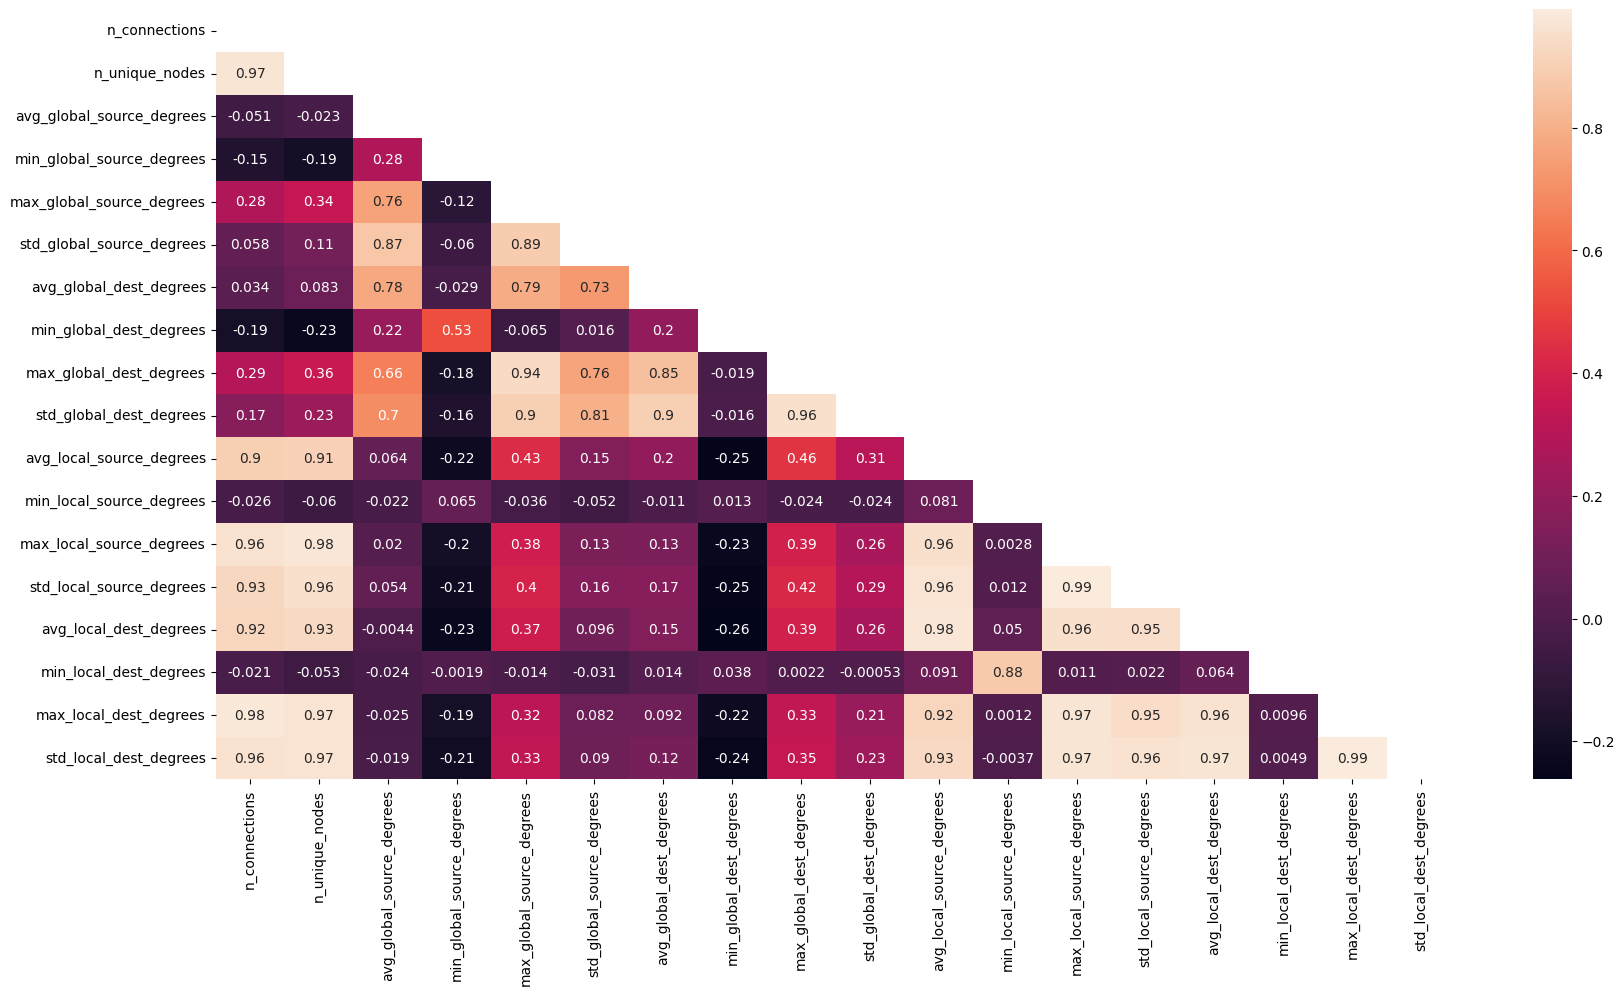

In [13]:
feature_corrs = graph_features.select(engineered_features).to_pandas().dropna().corr()
feature_corrs.index = feature_corrs.columns
matrix = np.triu(feature_corrs)
fig = plt.figure(figsize=(20, 10))
sns.heatmap(feature_corrs, annot=True, mask=matrix)

We can see clear groups of highyl correlated features. Hence, let's apply `SmartCorrelatedSelection` to reduce the feature set of engineered features

In [14]:
features_pd = graph_features.select(engineered_features).to_pandas().dropna()

tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.95,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
)

tr.fit(features_pd)

print('Features to drop:')
for f in tr.features_to_drop_:
    print(f)

Features to drop:
std_global_dest_degrees
n_unique_nodes
max_local_source_degrees
max_local_dest_degrees
std_local_dest_degrees
avg_local_dest_degrees
avg_local_source_degrees


**Observations:**
* Engineered features have groups of high correlation

**Impact**
* `['n_unique_nodes', 'std_global_dest_degrees', 'avg_local_source_degrees', 'max_local_source_degrees', 'avg_local_dest_degrees', 'max_local_dest_degrees' 'std_local_dest_degrees']` are dropped from the features list due to belonging to a high correlation set and having lower variance than the remaining feature